# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC
import os
from glob import glob
import nltk
import string
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### Основные нужные формулы производных:

$$log^{'}(x)=\frac{1}{x}$$

$$\sigma^{'}(x)=\sigma(x)(1-\sigma(x))$$

$$(||w||_{1})^{'}=sign(x)$$

$$(||w||_{2}^{2})^{'}=2w$$

##### Посчитаем производные компонент:

$$\sigma_{w}^{'}(w^{T}x)=x\sigma(w^{T}x)(1-\sigma(w^{T}x))$$
$$log_{w}^{'}(\sigma(w^{T}x))=\frac{x\sigma(w^{T}x)(1-\sigma(w^{T}x))}{\sigma(w^{T}x)}=x(1-\sigma(w^{T}x))$$
$$log_{w}^{'}(1-\sigma(w^{T}x))=\frac{-x\sigma(w^{T}x)(1-\sigma(w^{T}x))}{(1-\sigma(w^{T}x)}=-x\sigma(w^{T}x)$$

##### Найдем градиент фукнции:
$$\nabla_{w}L(w)=\sum_{i=1}^{N}-y_{i}x_{i}(1-\sigma(w^{T}x_{i}))+(1-y_{i})x_{i}\sigma(w^{T}x_{i})+\gamma\cdot sign(w)+2\beta w$$
$$\nabla_{w}L(w)=\sum_{i=1}^{N}-y_{i}x_{i}+y_{i}x_{i}\sigma(w^{T}x_{i})+x_{i}\sigma(w^{T}x_{i})-y_{i}x_{i}\sigma(w^{T}x_{i})+\gamma\cdot sign(w)+2\beta w$$
$$\nabla_{w}L(w)=\sum_{i=1}^{N}x_{i}(\sigma(w^{T}x_{i})-y_{i})+\gamma\cdot sign(w)+2\beta w$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    return np.sum((-y * np.log(1 / (1 + np.exp(-np.dot(X, w.T))))) - ((1 - y) * np.log(1 - (1 / (1 + np.exp(-np.dot(X, w.T))))))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w)

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w = np.dot(((1 / (1 + np.exp(-np.dot(X, w.T)))) - y), X) + gamma * np.sign(w) + 2 * beta * w
    return grad_w

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = []
        self.classes = np.array([0, 1])
        np.random.seed(random_state)
        
    def fit(self, X, y):
        X = sm.add_constant(np.array(X))
        y = np.array(y)
        self.w = np.random.normal(0, 1, size=(X.shape[1], ))

        for i in range(self.max_iter):
            gradient = get_grad(X, y, self.w, self.gamma, self.beta)
            self.w -= self.learning_rate * gradient
            self.loss_history.append(loss(X, y, self.w, self.gamma, self.beta))

            if np.linalg.norm(gradient) < self.tolerance:
                break

        return self

    def predict(self, X):
        return (self.predict_proba(X)[0] > self.predict_proba(X)[1]).astype(int)

    def predict_proba(self, X):
        X = sm.add_constant(np.array(X))
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

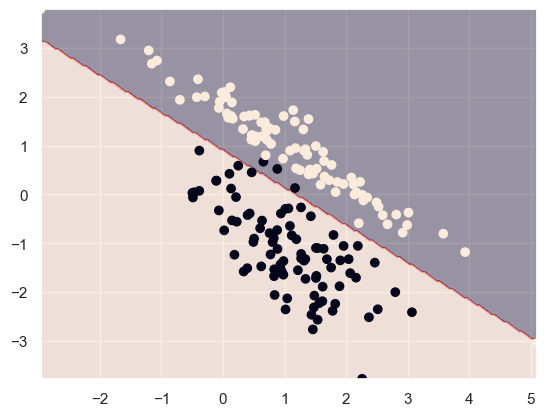

In [9]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

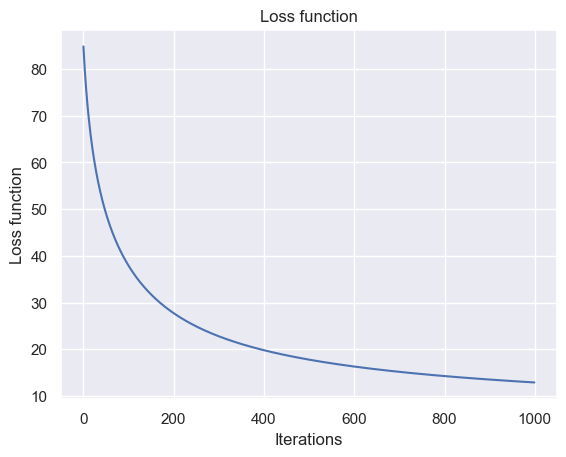

In [10]:
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.plot(model.loss_history)
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [11]:
# Разделим выборку на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определим параметры для моделей
models = {
     "linear": {"params": dict(kernel='linear')},
     "poly2": {"params": dict(kernel='poly', degree=2)},
     "poly3": {"params": dict(kernel='poly', degree=3)},
     "poly4": {"params": dict(kernel='poly', degree=4)},
     "rbf(g=0.5)": {"params": dict(kernel='rbf', gamma=0.5)},
     "rbf(g=1)": {"params": dict(kernel='rbf', gamma=1)}
}

# Зададим значения коэффициента регуляризации
reg_coef = np.logspace(-3, 3, num = 30)

# Создадим функцию для подсчета основных параметров
def find_scores(X, y, result, model):
     y_pred = model.predict(X)
     result['accuracy'].append(accuracy_score(y, y_pred))
     result['roc_auc'].append(roc_auc_score(y, y_pred))
     result['f1'].append(f1_score(y, y_pred))

In [12]:
# Найдем основные оказатели в зависимости от коэффициента регуляризации
for model in models.values():
    model['scores'] = {'accuracy': [], 'roc_auc': [], 'f1': []}
    for coef in reg_coef:
        svm = SVC(**model['params'], C=coef)
        svm.fit(X_train, y_train)
        find_scores(X_test, y_test, model['scores'], svm)

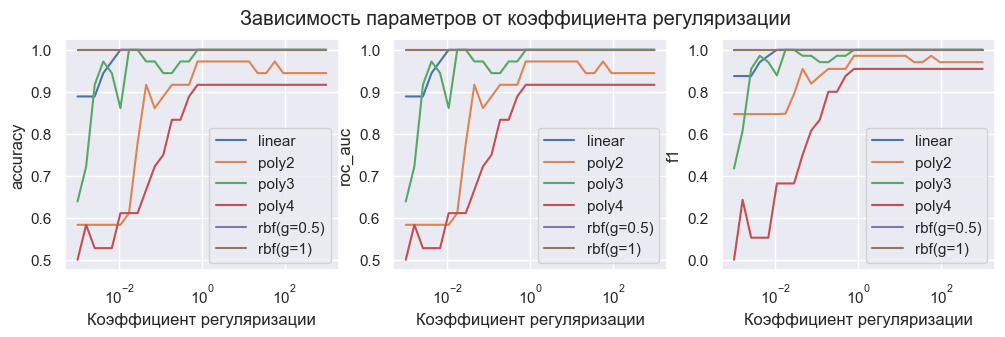

In [13]:
# Визуализация
def visualize(kernel, axes, score='f1'):
    axes.set_xscale("log")
    axes.set_xlabel('Коэффициент регуляризации')
    axes.set_ylabel(score)
    axes.plot(reg_coef, models[kernel]['scores'][score], label=kernel)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.suptitle('Зависимость параметров от коэффициента регуляризации')
for axes, score in zip(axs, ['accuracy', 'roc_auc', 'f1']):
    for kernel in models:
        visualize(kernel, axes, score)
    axes.legend()
plt.show()

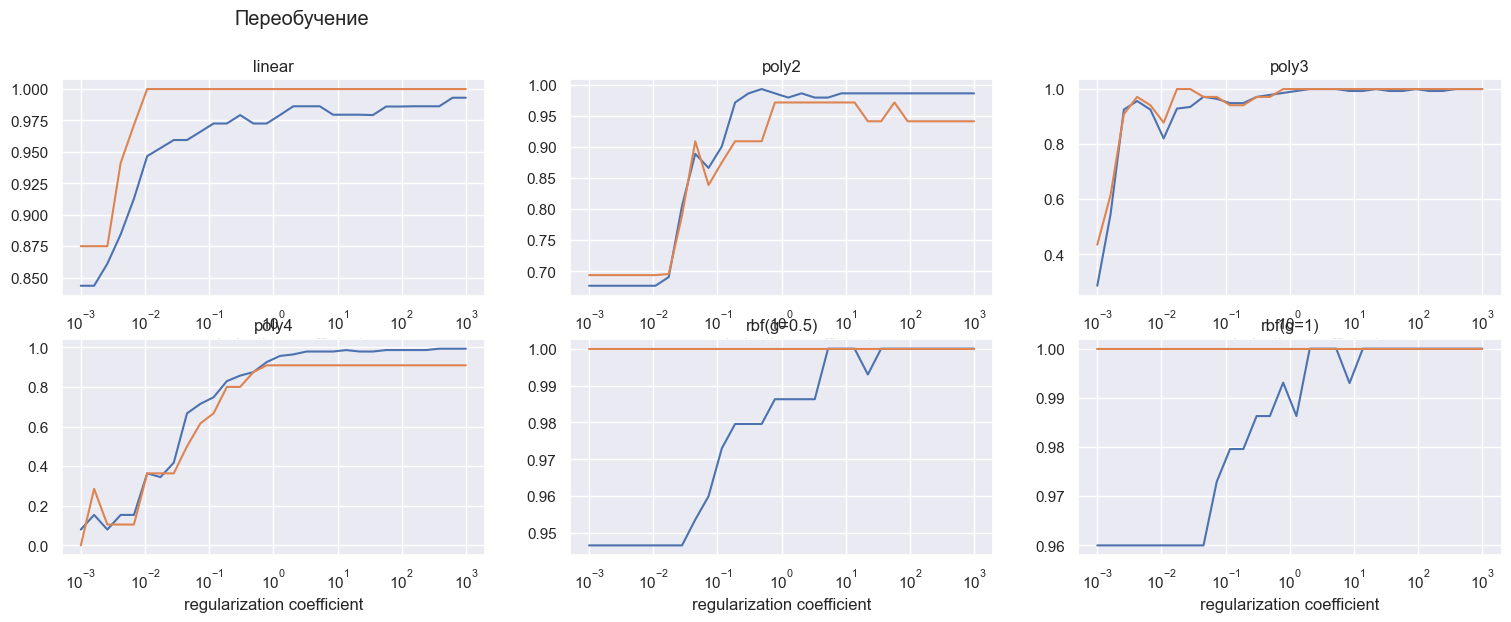

In [14]:
# Переобучение
overfit = {
    "linear": {"train_scores": [], 'test_scores': []},
    "poly2": {"train_scores": [], 'test_scores': []},
    "poly3": {"train_scores": [], 'test_scores': []},
    "poly4": {"train_scores": [], 'test_scores': []},
    "rbf(g=0.5)": {"train_scores": [], 'test_scores': []},
    "rbf(g=1)": {"train_scores": [], 'test_scores': []},
}

for model in overfit:
    overfit[model]['train_scores'] = {'accuracy': [], 'roc_auc': [], 'f1': []}
    overfit[model]['test_scores'] = {'accuracy': [], 'roc_auc': [], 'f1': []}
    for coef in reg_coef:
        svm = SVC(**models[model]['params'], C=coef)
        svm.fit(X_train, y_train)
        find_scores(X_test, y_test, overfit[model]['test_scores'], svm)
        find_scores(X_train, y_train, overfit[model]['train_scores'], svm)


def reformat(axes):
     return [i for array in axes for i in array]
        

def visuailize_overfit(axes, kernel, score="f1", set=None):
    axes.set_xscale("log")
    axes.set_xlabel("regularization coefficient")
    axes.set_title(kernel)
    axes.plot(reg_coef, overfit[kernel][set][score])
    

fig, axs = plt.subplots(2,3, figsize=(12, 7))
fig.subplots_adjust(left=0.3, right=1.5, bottom=0.2)
fig.suptitle("Переобучение")
for axes, kernel in zip(reformat(axs), overfit):
    visuailize_overfit(axes, kernel, set="train_scores")
    visuailize_overfit(axes, kernel, set="test_scores")
plt.show()

#### Таким образом мы можем увидеть, что больше всего на коэффициент регуляризации реагирует полином четвертой степени. Также полином второй и четвертой степени больше подвержены переобучению

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [15]:
import random

np.random.seed(42)

# Определим параметры для каждого автора
params = {
    'Горький' : {'path' : './prose/Gorky', 'sentance_count': 5000},
    'Тургенев' : {'path' : './prose/Turgenev', 'sentance_count': 15000},
    'Достоевский' : {'path' : './prose/Dostoevsky', 'sentance_count': 8000},
    'Пушкин' : {'path' : './prose/Pushkin', 'sentance_count': 11000},
    'Толстой' : {'path' : './prose/Tolstoy', 'sentance_count': 20000},
    'Лермонтов' : {'path' : './prose/Lermontov', 'sentance_count': 3000},
}

# Функция для считывания всех файлов определенного автора
def get_sentences(directory, sentences_count):
    result = []
    for file in os.listdir(directory):
        with open(f'{directory}/{file}', 'r', encoding='utf-8') as f:
            text = f.read()
            sentences = nltk.sent_tokenize(text, language='russian')           
            for sentence in sentences:
                if(len(sentence.split())) > 15:
                    result.append(sentence) 
            result.extend(sentences)
    return result

data = pd.DataFrame(columns=['sentence', 'author']) 

for author in params:
    sentences = get_sentences(params[author]['path'], params[author]['sentance_count'])
    df = pd.DataFrame({'sentence': sentences, 'author': author})
    if df.shape[0] > params[author]['sentance_count']:
        df = df[:params[author]['sentance_count']]
    data = pd.concat([df, data])

data = data.sample(frac=1)
data

,sentence,author
3319,"Лиза чуть-чуть было привстала, но тотчас же оп...",Достоевский
593,"Тебе нужны не сошки, а стропила, перемёты, сто...",Толстой
14933,"– говорил Левин, совершенно забыв вчерашний не...",Толстой
50,"На другой день собралось много народа слушать,...",Толстой
4238,"И как будто ты… немножко того, а?",Горький
...,...,...
12343,"это и прежде не имело никакого смысла, а тепер...",Тургенев
4158,– вскочил он с места с исказившимся лицом; но ...,Достоевский
860,"Друзья,\nкоторые завтра меня забудут или, хуже...",Лермонтов
12795,"Левин, ставивший между тем ружье в шкаф, уже в...",Толстой


In [16]:
import nltk
from nltk.stem.snowball import SnowballStemmer 

# Загрузим стоп слова
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

word_tokenizer = nltk.WordPunctTokenizer()
stemmer = SnowballStemmer("russian")

def process_data(sentence):   
        text_lower = sentence.lower() 
        tokens     = word_tokenizer.tokenize(text_lower)
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words)]
        result_tokens = ' '.join([stemmer.stem(token) for token in tokens])
        return result_tokens


data['processed_sentence'] = data['sentence'].apply(process_data)
data

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


,sentence,author,processed_sentence
3319,"Лиза чуть-чуть было привстала, но тотчас же оп...",Достоевский,лиз привста тотчас опуст мест обрат должн вним...
593,"Тебе нужны не сошки, а стропила, перемёты, сто...",Толстой,теб нужн сошк строп перемет столб нов нужн ска...
14933,"– говорил Левин, совершенно забыв вчерашний не...",Толстой,– говор левин совершен заб вчерашн неприятн ра...
50,"На другой день собралось много народа слушать,...",Толстой,ден собра народ слуша рассуд суд
4238,"И как будто ты… немножко того, а?",Горький,… немножк
...,...,...,...
12343,"это и прежде не имело никакого смысла, а тепер...",Тургенев,эт прежд имел никак смысл подавн
4158,– вскочил он с места с исказившимся лицом; но ...,Достоевский,– вскоч мест исказ лиц трудн испуга торжествов...
860,"Друзья,\nкоторые завтра меня забудут или, хуже...",Лермонтов,друз котор завтр забудут хуж возведут счет бог...
12795,"Левин, ставивший между тем ружье в шкаф, уже в...",Толстой,левин став руж шкаф выход двер услыха слов куп...


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of words
vectorizer = CountVectorizer(max_features = 300)
vectorizer.fit(data['sentence'])

bag_vectorize = vectorizer.transform(data['sentence'])

bag_vectorize.todense()[:2]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

# tf-idf
vectorizer = TfidfVectorizer(max_features = 500)
vectorizer.fit(data['sentence'])

tf_vectorize = vectorizer.transform(data['sentence'])

tf_vectorize.todense()[:2]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.18107213, 0.        , 0.1467738 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.24540643,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

#### Разница между этими двумя способами заключается в том, что Bag of words считает матрицу, столбцами которой являются слова, а строками - предложения. Элемент матрицы принимает значения 1, если слово есть в предложении, и 0 в противном случае.

#### tf-idf же отражает важность слова в конкретном предложении, относительно других предложений, где это слово встречается.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [20]:
# Выберем 2-х авторов
data = data[(data['author'] == 'Тургенев') | (data['author'] == 'Пушкин')]
data

,sentence,author,processed_sentence
2862,"Гринев, узнав от него об нашей опасности, веле...",Пушкин,грин узна наш опасн велел сад скомандова марш ...
3481,После маленького предисловия вынул я из карман...,Пушкин,маленьк предислов вынул карма тетрадк прочел с...
3247,"Он искренно любил, он глубоко уважал свою моло...",Тургенев,искрен люб глубок уважа молод родственниц окон...
7685,— простонала бедная Наташа.,Пушкин,— простона бедн наташ
1771,Старики до тех пор обдумывали все это каждый п...,Пушкин,старик тех пор обдумыва эт кажд друг друг пере...
...,...,...,...
5191,– Да не могу я остаться!,Тургенев,– мог оста
12886,"Под предлогом, что она не в состоянии занимать...",Тургенев,предлог состоян занима воспитан допуска глафир...
2732,"А говорю я вам все это для того, чтобы кончить...",Тургенев,говор эт конч поскор … трагикомед – прибав нов...
12343,"это и прежде не имело никакого смысла, а тепер...",Тургенев,эт прежд имел никак смысл подавн


In [21]:
# Посмотрим на баланс классов
data['author'].value_counts()

author
Тургенев    15000
Пушкин      11000
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

X = np.array(data['sentence'])
y = np.array(data['author'].apply(lambda x: 1 if x == 'Тургенев' else 0))

# Разделим выборку на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn.metrics import *

# Функция для отображения значения из 6 семинара
def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END .............................C=0.001, kernel=linear; total time=  10.0s
[CV] END .............................C=0.001, kernel=linear; total time=   9.9s
[CV] END ...............................C=0.001, kernel=poly; total time=  10.3s
[CV] END ...............................C=0.001, kernel=poly; total time=  10.5s
[CV] END ................................C=0.001, kernel=rbf; total time=  11.6s
[CV] END ................................C=0.001, kernel=rbf; total time=  11.7s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  11.2s
[CV] END ............................C=0.001, kernel=sigmoid; total time=  11.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   9.8s
[CV] END ..............................C=0.01, kernel=linear; total time=   9.9s
[CV] END ................................C=0.01, kernel=poly; total time=  10.6s
[CV] END ................................C=0.01,

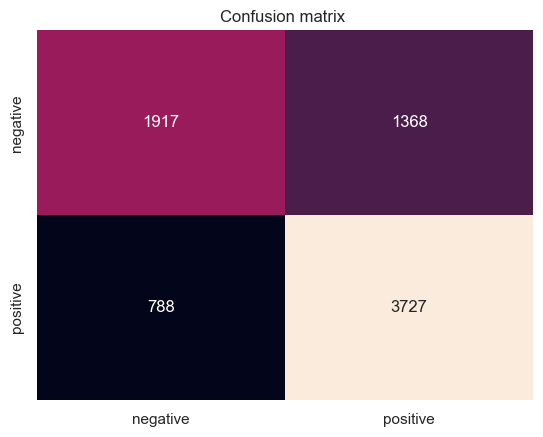

In [27]:
from sklearn.model_selection import GridSearchCV

# Исследуем модель SVM в зависимости от параметров
params = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
}

word_grid = [100, 1000, 10000, 30000]

for i in word_grid:
    vectorizer = TfidfVectorizer(max_features = i)
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    svm = SVC(verbose = False, probability = True)
    clf = GridSearchCV(svm, params, scoring = 'f1', verbose=2, cv=2)
    clf.fit(X_train_vectorized, y_train)
    print(f'Best params: {clf.best_params_}, word_grid={i}')
    pred = clf.predict(X_test_vectorized)
    proba  = clf.predict_proba(X_test_vectorized)
    show_results(y_test, pred, proba)

In [ ]:
# Исследуем зависимость f1 и параметров
f1 = []
c = []
for C in params['C']:
    vectorizer = TfidfVectorizer(max_features = 100)
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    svm = SVC(kernel='rbf', C=C, verbose = False, probability = True)
    clf.fit(X_train_vectorized, y_train)
    pred = clf.predict(X_test_vectorized)
    proba  = clf.predict_proba(X_test_vectorized)
    show_results(y_test, pred, proba)
    c.append(C)
    f1.append(f1_score(y_test, pred, average='macro'))

plt.plot(c, f1)
plt.title('F1 and C')
plt.xlabel('C')
plt.ylabel('F1')
plt.show()

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here